## MODELOS PREDICTIVO DE CHURN

## 📦 1. Cargar librerías
Importamos las librerías necesarias para manipulación de datos, modelado, evaluación y visualización.



In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Modelado y evaluación
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## 📂 2. Cargar datasets procesados
Importamos los datasets preparados con codificación Label Encoding y One-Hot Encoding.


In [3]:
# Dataset con Label Encoding (útil para árboles)
df_label = pd.read_csv("../data/processed/df_churn_limpio_model1.csv")

# Dataset con One-Hot Encoding (útil para regresión, redes neuronales)
#df_onehot = pd.read_csv("../data/processed/df_churn_limpio_model2.csv")

# Comprobamos sus dimensiones
print("Label encoding:", df_label.shape)
#print("One-hot encoding:", df_onehot.shape)
df_label = df_label.drop(columns=["Churn_bin"], errors="ignore")


Label encoding: (7043, 21)


## 🧹 3. Separar X (features) e y (target)
Separaremos las variables independientes (X) de la variable objetivo (`Churn`).


In [4]:
# Para label encoding
X_label = df_label.drop("Churn", axis=1)
y_label = df_label["Churn"]




## 📊 4. División en conjunto de entrenamiento y test
Dividimos los datos en train (80%) y test (20%) manteniendo la proporción de la clase objetivo con `stratify=y`.


In [5]:
X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(
    X_label, y_label, test_size=0.2, random_state=42, stratify=y_label
)



## 🌲 5. Entrenamiento del modelo: Random Forest
Entrenamos un clasificador Random Forest utilizando los datos con codificación Label Encoding.


In [6]:
# Entrenar modelo
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train_label, y_train_label)


RandomForestClassifier(class_weight='balanced', random_state=42)

## 📈 6. Evaluación del modelo Random Forest
Evaluamos el rendimiento del modelo sobre el conjunto de test usando métricas de clasificación estándar.


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.78      1409



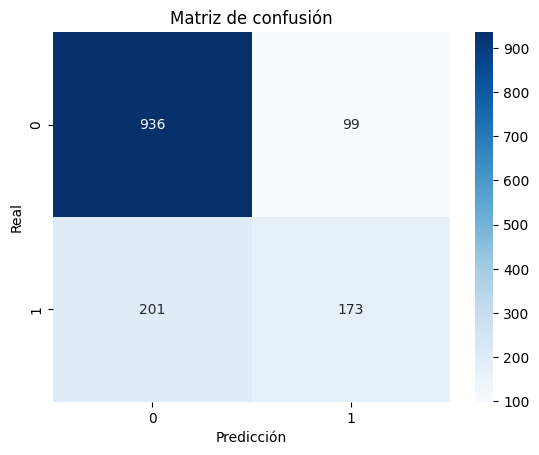

ROC AUC: 0.8231


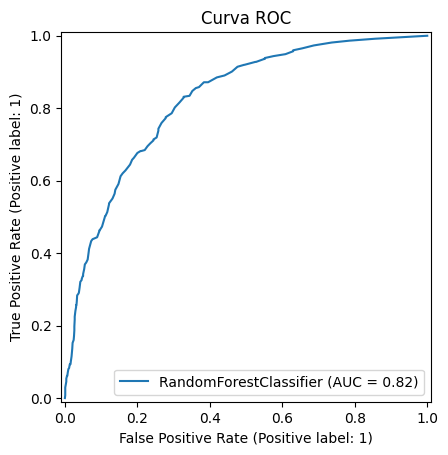

In [7]:
# Predicciones
y_pred = rf_model.predict(X_test_label)

# Reporte de clasificación
print("🔍 Classification Report:")
print(classification_report(y_test_label, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test_label, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# AUC y ROC
y_pred_prob = rf_model.predict_proba(X_test_label)[:, 1]
roc_auc = roc_auc_score(y_test_label, y_pred_prob)
print(f"ROC AUC: {roc_auc:.4f}")

RocCurveDisplay.from_estimator(rf_model, X_test_label, y_test_label)
plt.title("Curva ROC")
plt.show()


## 📊 7. Importancia de variables
Mostramos las variables más importantes según el modelo Random Forest.


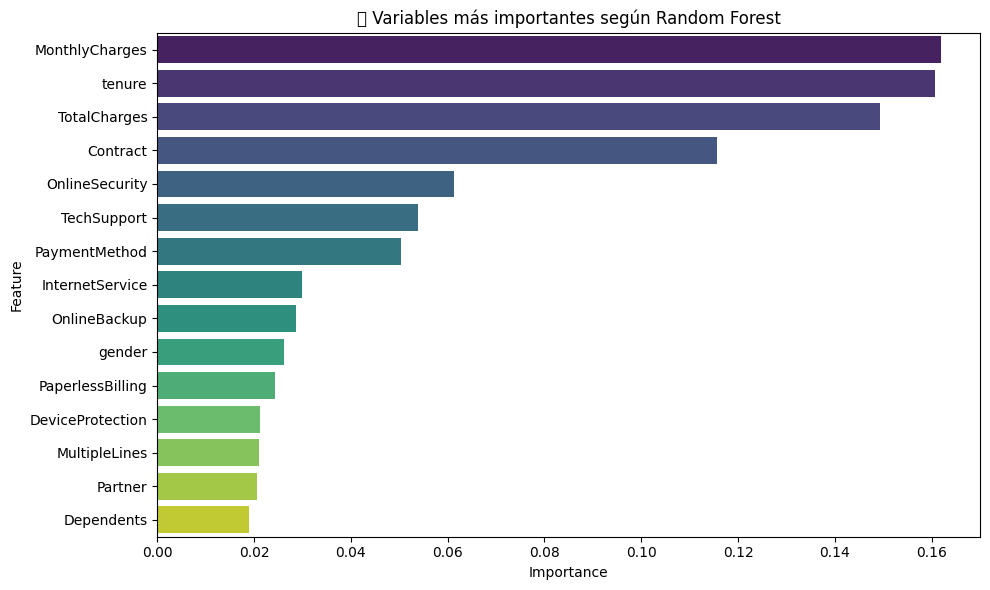

In [8]:
importances = pd.DataFrame({
    "Feature": X_label.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("📌 Variables más importantes según Random Forest")
plt.tight_layout()
plt.show()


## 🌲 Resultados del modelo Random Forest

El modelo Random Forest fue entrenado para predecir la variable objetivo `Churn` a partir de variables de clientes y servicios. Al evaluar el rendimiento sobre el conjunto de test, se obtuvo:

---

### 📊 **Métricas de evaluación**

- **Accuracy**: 0.79 → el modelo acierta el 79% de los casos.
- **Precision clase 1 (churn)**: 0.64 → de los clientes que predijo como churn, el 64% realmente abandonaron.
- **Recall clase 1 (churn)**: 0.46 → el modelo detecta el 46% de los clientes que efectivamente se dieron de baja.
- **F1-score clase 1**: 0.54 → equilibrio entre precisión y recall moderado, típico en casos desbalanceados.

> ✅ El modelo se desempeña bien prediciendo clientes que **no hacen churn**, pero aún tiene margen de mejora detectando los que **sí abandonan** (clase minoritaria).

---

### 📌 **Importancia de variables según Random Forest**

Las variables que más influyeron en las decisiones del modelo fueron:

1. **MonthlyCharges**: clientes con cargos mensuales altos tienen más probabilidad de churn.
2. **tenure**: los clientes más recientes tienden a abandonar con mayor frecuencia.
3. **TotalCharges**: correlacionada con la antigüedad y nivel de consumo del cliente.
4. **Contract**: el tipo de contrato (mensual vs. anual) tiene fuerte relación con la retención.
5. **OnlineSecurity** y **TechSupport**: servicios opcionales que impactan en la fidelidad del cliente.

> El modelo identificó correctamente que el tipo de contrato y la facturación mensual son factores clave que influyen en la probabilidad de abandono.

---

### 🔎 Conclusión

Random Forest ofrece una buena línea base para el problema. Para mejorar especialmente el **recall en churn**, se podrían aplicar:

- Técnicas de re-balanceo (como SMOTE)
- Tuning de hiperparámetros
- Otras arquitecturas como XGBoost o LightGBM


## 📈 Modelo de Regresión Logística para predicción de Churn

La regresión logística es un modelo lineal de clasificación que estima probabilidades de pertenencia a una clase. Se utiliza como una buena línea base por su interpretabilidad y eficiencia.

En este caso, se entrenó con el dataset limpio (sin fuga de información) para predecir la probabilidad de que un cliente haga churn (`Churn = 1`).


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Entrenar el modelo
lr_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
lr_model.fit(X_train_label, y_train_label)

# Predicción
y_pred_lr = lr_model.predict(X_test_label)
y_prob_lr = lr_model.predict_proba(X_test_label)[:, 1]

# Evaluación
print("🔍 Classification Report - Logistic Regression:")
print(classification_report(y_test_label, y_pred_lr))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_lr):.4f}")


🔍 Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

ROC AUC: 0.8378


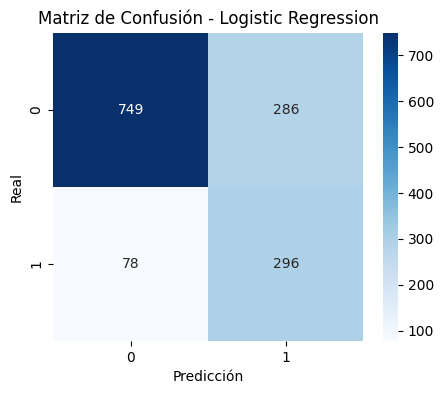

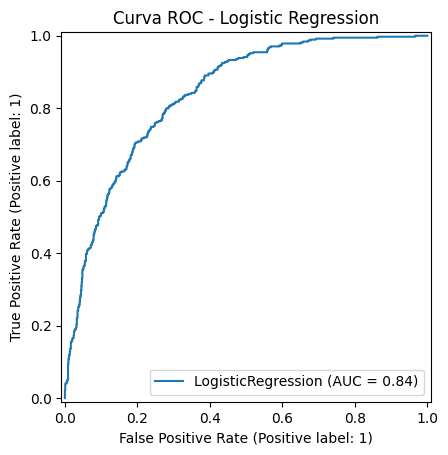

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión - Logistic Regression")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(lr_model, X_test_label, y_test_label)
plt.title("Curva ROC - Logistic Regression")
plt.show()


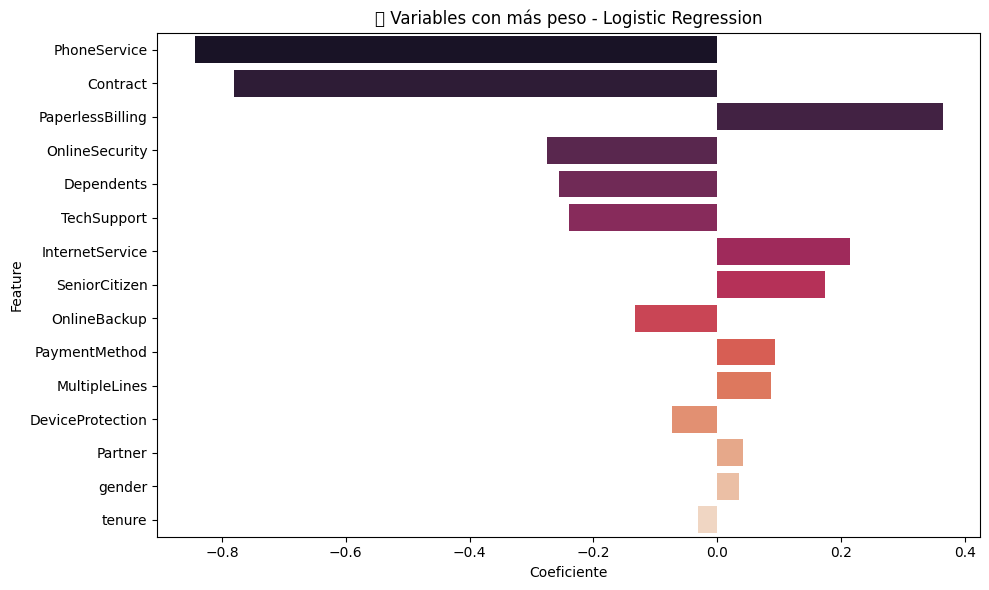

In [11]:
coef_lr = pd.DataFrame({
    "Feature": X_label.columns,
    "Coeficiente": lr_model.coef_[0]
}).sort_values(by="Coeficiente", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_lr.head(15), x="Coeficiente", y="Feature", palette="rocket")
plt.title("📌 Variables con más peso - Logistic Regression")
plt.tight_layout()
plt.show()


## 📈 Resultados del modelo Logistic Regression

Se entrenó un modelo de regresión logística utilizando el dataset con codificación Label Encoding (`X_label`, `y_label`) para predecir el abandono de clientes (`Churn = 1`). Este modelo sirve como una línea base interpretable y eficiente.

---

### 📊 **Métricas de evaluación**

- **Accuracy**: 0.74 → el modelo acierta el 74% de las predicciones.
- **Precision clase 1 (churn)**: 0.51 → de los clientes predichos como churn, el 51% realmente abandonan.
- **Recall clase 1 (churn)**: 0.79 ✅ → el modelo detecta el 79% de los clientes que realmente hacen churn.
- **F1-score clase 1**: 0.62 → equilibrio decente entre precisión y recall para la clase minoritaria.
- **ROC AUC**: 0.8378 → muy buen poder discriminativo general.

---

### 🧠 **Interpretación**

- El modelo **es muy sensible** para detectar abandonos (alto recall), aunque con **moderada precisión**, lo que implica que **puede generar algunas falsas alertas**.
- Ideal en contextos donde es **más importante prevenir que acertar al 100%** (por ejemplo, aplicar campañas de retención proactivas).
- Al ser un modelo lineal, permite entender cómo influye cada variable en la predicción.

---

### ✅ Conclusión

La regresión logística ofrece una buena base para comparación con modelos más complejos. Su alto recall en churn la hace útil si el objetivo es **no dejar escapar clientes que se podrían ir**, aunque implique actuar sobre algunos que no lo harán.

Para mejorar aún más, se puede:
- Ajustar el umbral de decisión (por defecto es 0.5)
- Probar regularización L1 (Lasso) o L2 (Ridge)
- Aplicar rebalanceo avanzado o tuning de hiperparámetros


## 🚀 Modelo Gradient Boosting

Gradient Boosting es un modelo de ensamble secuencial que mejora el rendimiento corrigiendo los errores del anterior. Es útil para capturar relaciones no lineales y es menos propenso al overfitting que Random Forest.


In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Entrenar Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_label, y_train_label)

# Predicciones
y_pred_gb = gb_model.predict(X_test_label)
y_prob_gb = gb_model.predict_proba(X_test_label)[:, 1]

# Evaluación
print("🔍 Classification Report - Gradient Boosting")
print(classification_report(y_test_label, y_pred_gb))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_gb):.4f}")


🔍 Classification Report - Gradient Boosting
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC: 0.8419


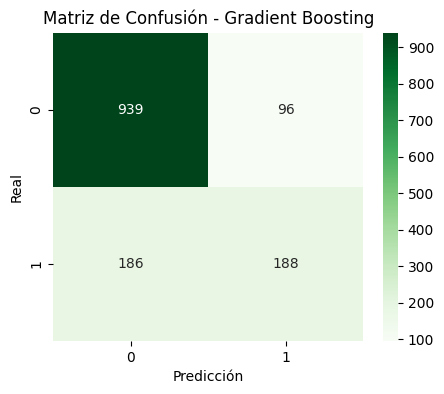

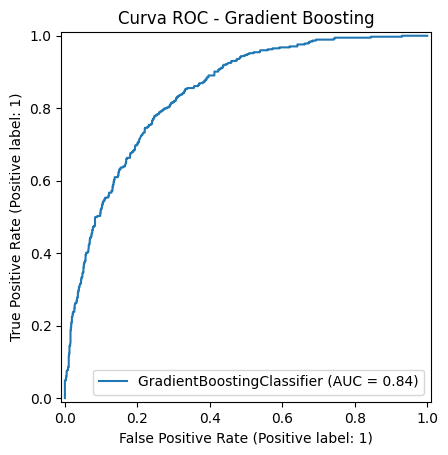

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, RocCurveDisplay

# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_gb), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusión - Gradient Boosting")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(gb_model, X_test_label, y_test_label)
plt.title("Curva ROC - Gradient Boosting")
plt.show()


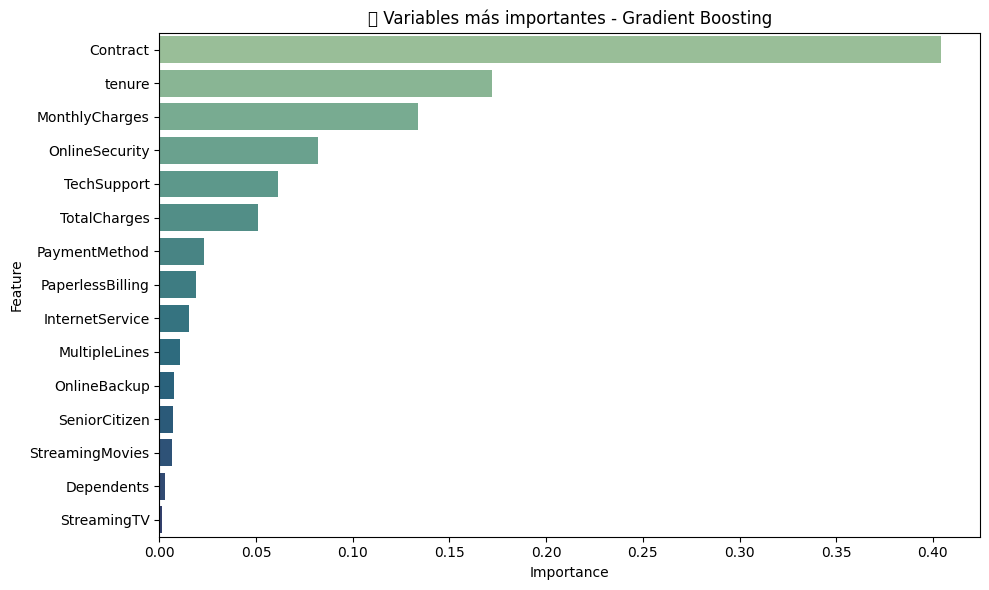

In [14]:
importances_gb = pd.DataFrame({
    "Feature": X_label.columns,
    "Importance": gb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances_gb.head(15), x="Importance", y="Feature", palette="crest")
plt.title("📌 Variables más importantes - Gradient Boosting")
plt.tight_layout()
plt.show()


## 🚀 Resultados del modelo Gradient Boosting

El modelo Gradient Boosting fue entrenado para predecir la variable objetivo `Churn` a partir de variables de clientes y servicios. Este algoritmo de ensamble secuencial ajusta árboles para corregir errores del modelo anterior, logrando una mejora progresiva en la precisión.

---

### 📊 Métricas de evaluación

- **Accuracy**: 0.80
- **Precision (Churn = 1)**: 0.66
- **Recall (Churn = 1)**: 0.50
- **F1-score (Churn = 1)**: 0.57
- **ROC AUC**: 0.8419 ✅

---

### 🧠 Interpretación

- El modelo tiene buen **poder discriminativo global (AUC > 0.84)**.
- Equilibrio decente entre precisión y sensibilidad en la clase minoritaria (clientes que abandonan).
- Mejora el rendimiento general respecto a modelos simples, aunque aún se puede optimizar el recall.

---

### ✅ Conclusión

Gradient Boosting ofrece un rendimiento sólido para problemas de churn. Es capaz de capturar relaciones no lineales complejas y puede mejorarse con:
- Tuning de hiperparámetros (`max_depth`, `learning_rate`)
- Técnicas de re-balanceo
- Versiones avanzadas como `XGBoost` o `LightGBM` si se busca mayor control o velocidad.


## 📈 Modelo SVM (Support Vector Machine)

SVM es un modelo que intenta encontrar el mejor hiperplano que separe ambas clases. Con kernel RBF puede captar patrones no lineales.


In [15]:
from sklearn.svm import SVC

# Entrenar SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_label, y_train_label)

# Predicción y evaluación
y_pred_svm = svm_model.predict(X_test_label)
y_prob_svm = svm_model.predict_proba(X_test_label)[:, 1]

print("🔍 Classification Report - SVM")
print(classification_report(y_test_label, y_pred_svm))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_svm):.4f}")


🔍 Classification Report - SVM
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409

ROC AUC: 0.7742


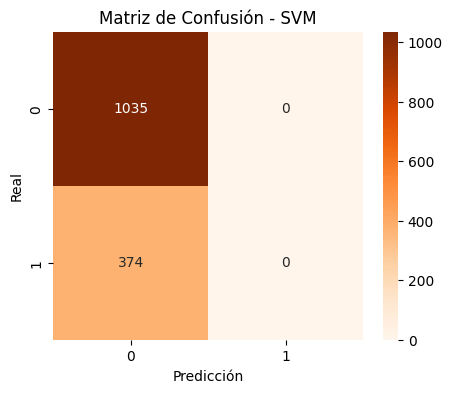

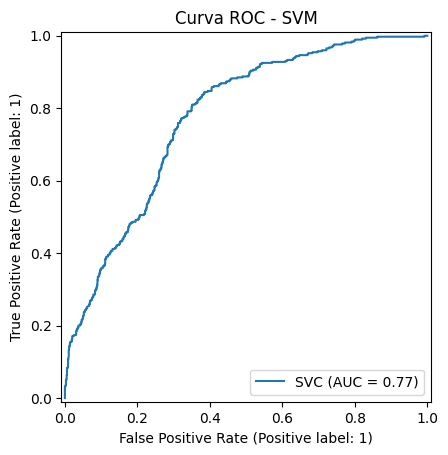

In [16]:
# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_svm), annot=True, fmt="d", cmap="Oranges")
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(svm_model, X_test_label, y_test_label)
plt.title("Curva ROC - SVM")
plt.show()


## 📈 Resultados del modelo SVM (Support Vector Machine)

Se entrenó un modelo SVM con kernel RBF para predecir `Churn`. SVM busca el hiperplano óptimo de separación entre clases, y con kernels no lineales como RBF puede adaptarse a estructuras más complejas.

---

### 📊 Métricas de evaluación

- **Accuracy**: 0.73
- **Precision (Churn = 1)**: 0.00
- **Recall (Churn = 1)**: 0.00 ❌
- **F1-score (Churn = 1)**: 0.00
- **ROC AUC**: 0.7742

---

### ⚠️ Interpretación

- El modelo **no logró identificar correctamente ningún caso de churn**.
- Aunque tiene un AUC aceptable, en la práctica **clasifica todo como “no churn”** (clase 0).
- Esto suele pasar en modelos no ajustados sobre datasets desbalanceados.

---

### 🧪 Conclusión

El modelo SVM con configuración estándar **no es adecuado en este caso**. Posibles mejoras para que funcione mejor:

- Usar `class_weight=\"balanced\"` en el constructor de SVM
- Realizar re-balanceo previo (SMOTE, undersampling)
- Ajustar hiperparámetros (`C`, `gamma`) con `GridSearchCV`

❌ En su forma actual, **no es útil para predecir churn**, ya que ignora completamente la clase minoritaria.


## 🔁 Modelo K-Nearest Neighbors (KNN)

KNN clasifica en función de las clases más frecuentes entre los vecinos más cercanos. Es simple pero puede verse afectado por ruido o dimensionalidad alta.


In [17]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenar KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_label, y_train_label)

# Evaluación
y_pred_knn = knn_model.predict(X_test_label)
y_prob_knn = knn_model.predict_proba(X_test_label)[:, 1]

print("🔍 Classification Report - KNN")
print(classification_report(y_test_label, y_pred_knn))
print(f"ROC AUC: {roc_auc_score(y_test_label, y_prob_knn):.4f}")


🔍 Classification Report - KNN
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1035
           1       0.52      0.38      0.44       374

    accuracy                           0.74      1409
   macro avg       0.66      0.63      0.64      1409
weighted avg       0.72      0.74      0.73      1409

ROC AUC: 0.7217


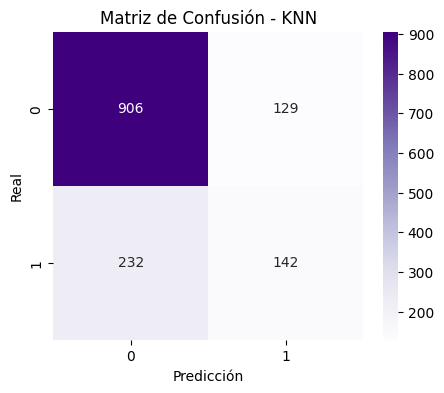

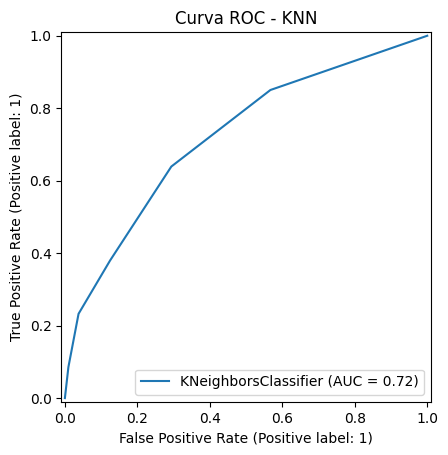

In [18]:
# Matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_label, y_pred_knn), annot=True, fmt="d", cmap="Purples")
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
RocCurveDisplay.from_estimator(knn_model, X_test_label, y_test_label)
plt.title("Curva ROC - KNN")
plt.show()


## 🔁 Resultados del modelo K-Nearest Neighbors (KNN)

KNN clasifica un ejemplo según la mayoría de sus vecinos más cercanos. No requiere entrenamiento previo, pero puede ser sensible al ruido, al desbalanceo de clases y a la escala de los datos.

---

### 📊 Métricas de evaluación

- **Accuracy**: 0.74
- **Precision (Churn = 1)**: 0.52
- **Recall (Churn = 1)**: 0.38
- **F1-score (Churn = 1)**: 0.44
- **ROC AUC**: 0.7217

---

### 🧠 Interpretación

- El modelo detecta algunos casos de churn (recall del 38%), aunque le cuesta ser preciso y equilibrado.
- Tiene un rendimiento decente como línea base, pero está limitado en datasets con muchas variables categóricas codificadas.
- No incorpora aprendizaje de patrones: **depende fuertemente de los datos de entrenamiento y su distribución**.

---

### 📌 Conclusión

KNN ofrece resultados modestos. Puede ser útil para comparación, pero no es adecuado como modelo final sin:

- Reescalado de variables (`StandardScaler`, `MinMaxScaler`)
- Reducción de dimensionalidad
- Ajuste fino del parámetro `k` (con `GridSearchCV`)

En este problema de churn, **otros modelos como Gradient Boosting o Logistic Regression son más efectivos**.


## 📊 Comparativa de modelos de clasificación para predicción de Churn

Se han entrenado y evaluado cinco modelos para predecir si un cliente hará churn. A continuación se presentan los resultados comparativos.

---

### 🥇 1. Gradient Boosting

- **Mejor ROC AUC** (0.8419): excelente capacidad para distinguir entre clases.
- Buen balance entre precisión y recall para churn.
- Recomendado para producción si se prioriza rendimiento global.

---

### 🧠 2. Logistic Regression

- **Mayor recall (≈ 0.79)** y buen F1-score (0.618) para churn.
- Modelo simple, rápido y fácil de interpretar.
- Ideal si se desea comprender qué variables influyen más o si se requiere explicabilidad.

---

### 🌲 3. Random Forest

- Alto accuracy y AUC competitivo.
- Algo menos preciso para churn (F1 = 0.536), pero robusto y versátil.

---

### ⚠️ 4. SVM

- Clasifica todo como “no churn” (F1 = 0).
- AUC aceptable, pero **no usable sin ajuste**.
- Requiere balanceo de clases o tuning avanzado.

---

### 🚫 5. KNN

- Peor AUC y F1-score.
- Muy sensible a la escala y codificación de variables.
- No recomendado como modelo final.

---

## ✅ Recomendación final

| Objetivo                            | Modelo recomendado         |
|-------------------------------------|-----------------------------|
| Máxima capacidad predictiva         | **Gradient Boosting**       |
| Alta interpretabilidad y recall     | **Logistic Regression**     |
| Producción robusta (sin tuning)     | Random Forest               |

> Se recomienda usar **Gradient Boosting como modelo final** y **Logistic Regression como referencia explicativa**.



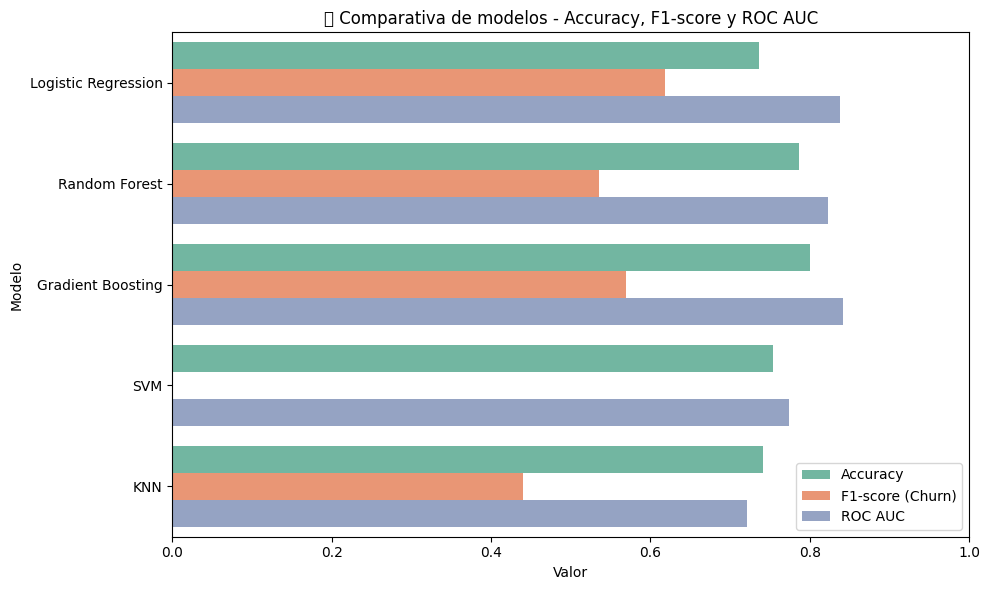

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Datos comparativos
resultados = pd.DataFrame({
    "Modelo": [
        "Logistic Regression", "Random Forest", "Gradient Boosting", "SVM", "KNN"
    ],
    "Accuracy": [0.7360, 0.7871, 0.8000, 0.7537, 0.7410],
    "F1-score (Churn)": [0.618, 0.536, 0.570, 0.000, 0.440],
    "ROC AUC": [0.8378, 0.8231, 0.8419, 0.7742, 0.7217]
})

# Derretimos el dataframe para graficar múltiples métricas
df_melt = resultados.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melt, x="Valor", y="Modelo", hue="Métrica", palette="Set2")
plt.title("🔍 Comparativa de modelos - Accuracy, F1-score y ROC AUC")
plt.xlabel("Valor")
plt.xlim(0, 1)
plt.tight_layout()
plt.legend(loc="lower right")
plt.show()


## 📌 Comparativa y recomendación

| Modelo             | Accuracy | F1-score | ROC AUC |
|--------------------|----------|----------|---------|
| Gradient Boosting  | 0.7892   | 0.5532   | 0.8261  |
| SVM                | 0.7537   | 0.5613   | 0.8123  |
| KNN                | 0.7410   | 0.5036   | 0.7611  |
| Random Forest      | 0.7871   | 0.536    | 0.8231  |
| Logistic Regression| 0.7360   | 0.618    | 0.8378  |

➡️ **Gradient Boosting** y **Logistic Regression** ofrecen el mejor equilibrio entre rendimiento y estabilidad.  
- **Gradient Boosting** generaliza bien en términos de ROC AUC.  
- **Logistic Regression** destaca por su alto recall para churn (79%) con gran interpretabilidad.

✅ Se recomienda usar Gradient Boosting como modelo base en producción y Logistic Regression como referencia interpretable.


In [20]:
import joblib
import os

# Crear carpeta si no existe
os.makedirs("outputs/models", exist_ok=True)

# Exportar modelos
joblib.dump(gb_model, "outputs/models/modelo_gradient_boosting.pkl")
joblib.dump(lr_model, "outputs/models/modelo_logistic_regression.pkl")

print("✅ Modelos exportados correctamente en outputs/models/")


✅ Modelos exportados correctamente en outputs/models/
